In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_regression, chi2

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier 
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, auc, roc_auc_score, roc_curve, classification_report, plot_roc_curve

In [2]:
pd.set_option("display.max_columns", None)
data = pd.read_csv("data/data.csv")
data = data.drop(["Unnamed: 32"], axis=1)
data

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [3]:
X = data.drop(["id", "diagnosis"], axis=1)
y = data["diagnosis"]
y = (y == "M").astype(int)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [6]:
# ML evaluation function

results = []

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(5, 3))
    group_names = ["TP", "FP", "FN", "TP"]
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_perc = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
    label = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_perc)]
    label = np.asarray(label).reshape(2, 2)
    heatmap = sns.heatmap(cm, annot=label, annot_kws={'size': 12}, fmt='', cmap='YlGnBu')
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='center', fontsize=10)
    plt.title('Confusion Matrix', fontsize=12, color='darkblue')
    plt.ylabel('True label', fontsize=10)
    plt.xlabel('Predicted label', fontsize=10)
    plt.show()

def plot_roc_curve(y_true, y_prob):
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_true, y_prob)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.figure(figsize=(5, 3))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, color='red', label='AUC = %0.2f' % roc_auc, linestyle="--")
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def ml_evaluation(model, model_name, X, y, X_train = X_train, y_train = y_train, classes=None, results=None):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    cm = confusion_matrix(y, y_pred)
    
    if classes is None:
        classes = ['Class %d' % i for i in range(len(cm))]
    
    plot_confusion_matrix(cm, classes)
    
    print("Classification Report:")
    print(classification_report(y, y_pred, target_names=classes, digits=4))
    
    if len(classes) == 2:
        try:
            best_params = model.best_params_
        except AttributeError:
            best_params = None

        try:
            best_cross_val_score = model.best_score_
        except AttributeError:
            best_cross_val_score = None

        try:
            train_accuracy = model.score(X_train, y_train)
        except:
            train_accuracy = None
            
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        auc = roc_auc_score(y, y_prob)
        
        evaluation_metrics = {
            "model": model_name,
            "best_params": best_params,
            "best_cross_val_score": best_cross_val_score,
            "train_accuracy": train_accuracy, 
            "test_accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1,
            "AUC": auc
        }
        
        print(evaluation_metrics)
        
        if results is not None:
            results.append(evaluation_metrics)
        
    plot_roc_curve(y, y_prob)    

In [22]:
def plot_learning_curve(model, X, y, cv=10, scoring='accuracy'):
    # Calculate learning curve
    train_sizes, train_scores, val_scores = learning_curve(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)

    # Calculate mean and standard deviation of training and validation scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Plot learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training Accuracy')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.3)
    plt.plot(train_sizes, val_mean, label='Validation Accuracy')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.3)
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.title('Learning Curve')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


# SVC with Transformer

In [20]:
numeric_features = list(range(len(X_train.columns.tolist())))
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('transformer', PowerTransformer(method='yeo-johnson')),
    ('scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features)
])

svm_params = {'C': 1, 'gamma': 1, 'kernel': 'rbf'}

svm = SVC(random_state=1, max_iter=500, probability=True, **svm_params)

pipe_svm_tf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('svm', svm)])

# Cross-validation scores
cv_scores = cross_val_score(pipe_svm_tf, X_train, y_train, cv=10, verbose=1)

# print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())
print("Standard deviation of CV accuracy:", cv_scores.std())

# Fit the model on the entire training set
pipe_svm_tf.fit(X_train, y_train)

# Evaluate model on train set
train_accuracy = pipe_svm_tf.score(X_train, y_train)
print("SVM train accuracy:", train_accuracy)

# Evaluate model on test set
test_accuracy = pipe_svm_tf.score(X_test, y_test)
print("SVM test accuracy:", test_accuracy)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.1s finished


Mean CV accuracy: 0.9779710144927536
Standard deviation of CV accuracy: 0.019662725946921724
SVM train accuracy: 0.9912087912087912
SVM test accuracy: 0.9824561403508771


In [14]:
cv_scores

array([1.        , 0.95652174, 1.        , 1.        , 0.95652174,
       0.95555556, 1.        , 0.97777778, 0.95555556, 0.97777778])

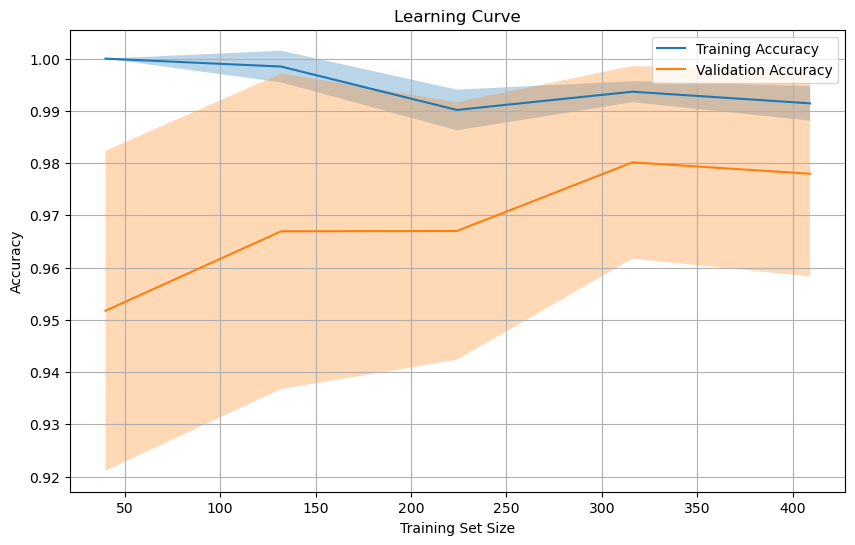

In [23]:
plot_learning_curve(pipe_svm_tf, X_train, y_train, cv=10, scoring='accuracy')

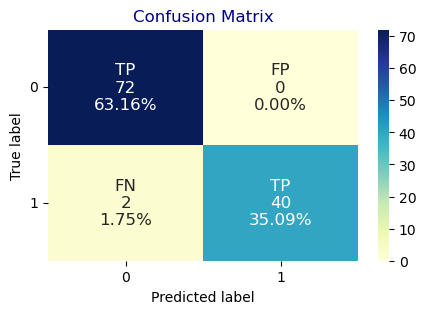

Classification Report:
              precision    recall  f1-score   support

      Benign     0.9730    1.0000    0.9863        72
   Malignant     1.0000    0.9524    0.9756        42

    accuracy                         0.9825       114
   macro avg     0.9865    0.9762    0.9810       114
weighted avg     0.9829    0.9825    0.9824       114

{'model': 'SVM with Transformation', 'best_params': None, 'best_cross_val_score': None, 'train_accuracy': 0.9912087912087912, 'test_accuracy': 0.9824561403508771, 'Precision': 1.0, 'Recall': 0.9523809523809523, 'F1-Score': 0.975609756097561, 'AUC': 0.9983465608465609}


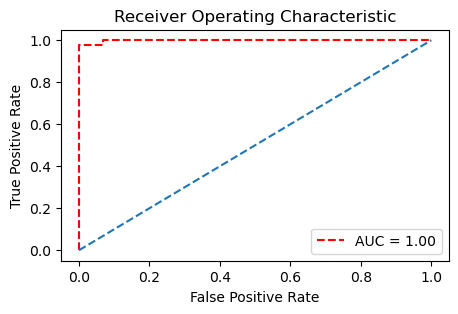

In [24]:
# model, model_name, X, y, classes=None
ml_evaluation(pipe_svm_tf, "SVM with Transformation", X_test, y_test, classes=["Benign", "Malignant"], results=results)

# SVC with Transformer and PCA

In [25]:
numeric_features = list(range(len(X_train.columns.tolist())))
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('transformer', PowerTransformer(method='yeo-johnson')),
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=0.95))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features)
])

svm_params = {'C': 1, 'gamma': 1, 'kernel': 'rbf'}

svm = SVC(random_state=1, max_iter=500, probability=True, **svm_params)

pipe_svm_pca = Pipeline(steps=[('preprocessor', preprocessor),
                              ('svm', svm)])

# Cross-validation scores
cv_scores = cross_val_score(pipe_svm_pca, X_train, y_train, cv=10, verbose=1)

# print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())
print("Standard deviation of CV accuracy:", cv_scores.std())

# Fit the model on the entire training set
pipe_svm_pca.fit(X_train, y_train)

# Evaluate model on train set
train_accuracy = pipe_svm_pca.score(X_train, y_train)
print("SVM train accuracy:", train_accuracy)

# Evaluate model on test set
test_accuracy = pipe_svm_pca.score(X_test, y_test)
print("SVM test accuracy:", test_accuracy)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.4s finished


Mean CV accuracy: 0.971304347826087
Standard deviation of CV accuracy: 0.019852897843934476
SVM train accuracy: 0.9912087912087912
SVM test accuracy: 0.9824561403508771


In [28]:
cv_scores

array([1.        , 0.95652174, 1.        , 1.        , 0.95652174,
       0.95555556, 0.97777778, 0.95555556, 0.95555556, 0.95555556])

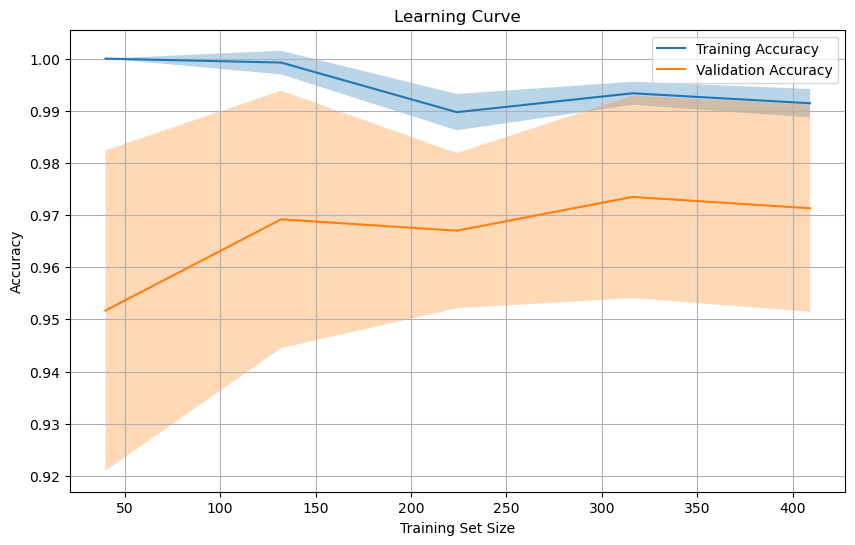

In [26]:
plot_learning_curve(pipe_svm_pca, X_train, y_train, cv=10, scoring='accuracy')

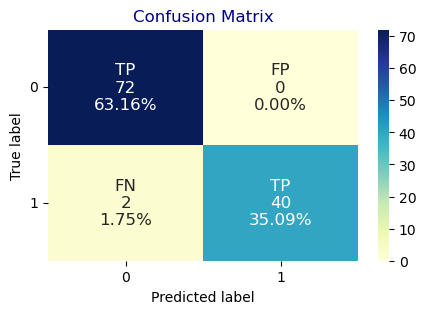

Classification Report:
              precision    recall  f1-score   support

      Benign     0.9730    1.0000    0.9863        72
   Malignant     1.0000    0.9524    0.9756        42

    accuracy                         0.9825       114
   macro avg     0.9865    0.9762    0.9810       114
weighted avg     0.9829    0.9825    0.9824       114

{'model': 'SVM with Transformation and PCA', 'best_params': None, 'best_cross_val_score': None, 'train_accuracy': 0.9912087912087912, 'test_accuracy': 0.9824561403508771, 'Precision': 1.0, 'Recall': 0.9523809523809523, 'F1-Score': 0.975609756097561, 'AUC': 0.9983465608465609}


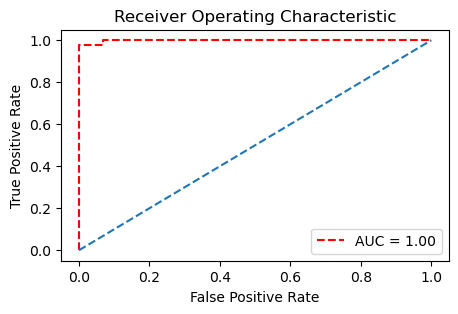

In [27]:
# model, model_name, X, y, classes=None
ml_evaluation(pipe_svm_pca, "SVM with Transformation and PCA", X_test, y_test, classes=["Benign", "Malignant"], results=results)